This notebook demonstrates how temporal (or spatial) covariates can be used for multimodal data integration to learn smooth latent factors while benefiting from the multimodal `MuData` objects from `muon`.

Please find more information about this method — *MEFISTO* — [on its website](https://biofam.github.io/MOFA2/MEFISTO) and [in the preprint](https://www.biorxiv.org/content/10.1101/2020.11.03.366674v1) by Britta Velten et al.

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

import muon as mu

import mofax

## Load data

First we will load the evodevo data containing normalized gene expression data for 5 species (groups) and 5 organs (views) as well as the developmental time information for each sample. The data can be downloaded [from here](https://figshare.com/s/242916198fde3353f3e6).

In [2]:
datadir = "data/evodevo"

In [3]:
data = pd.read_csv(f"{datadir}/evodevo.csv", sep=",", index_col=0)
data

/usr/local/lib/python3.8/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,group,view,sample,feature,value,time
1,Human,Brain,10wpc_Human,ENSG00000000457_Brain,8.573918,7
2,Human,Brain,10wpc_Human,ENSG00000001084_Brain,8.875957,7
3,Human,Brain,10wpc_Human,ENSG00000001167_Brain,11.265237,7
4,Human,Brain,10wpc_Human,ENSG00000001461_Brain,7.374965,7
5,Human,Brain,10wpc_Human,ENSG00000001561_Brain,7.311018,7
...,...,...,...,...,...,...
3193836,Human,Testis,youngMidAge_Human,ENSG00000271503_Testis,1.178014,21
3193837,Human,Testis,youngMidAge_Human,ENSG00000271601_Testis,1.178014,21
3193838,Human,Testis,youngMidAge_Human,ENSG00000272442_Testis,4.476201,21
3193839,Human,Testis,youngMidAge_Human,ENSG00000272886_Testis,1.178014,21


First, we create a collection of AnnData objects from this dataframe, one for each organ.

For instance, here's the data for the `'Brain'` view:

In [4]:
tt = data[data.view == 'Brain'].pivot(index='sample', columns='feature', values='value')
tt

feature,ENSG00000000457_Brain,ENSG00000001084_Brain,ENSG00000001167_Brain,ENSG00000001461_Brain,ENSG00000001561_Brain,ENSG00000001617_Brain,ENSG00000001629_Brain,ENSG00000001631_Brain,ENSG00000002549_Brain,ENSG00000002745_Brain,...,ENSG00000267909_Brain,ENSG00000268104_Brain,ENSG00000269058_Brain,ENSG00000270885_Brain,ENSG00000271092_Brain,ENSG00000271503_Brain,ENSG00000271601_Brain,ENSG00000272442_Brain,ENSG00000272886_Brain,ENSG00000273079_Brain
sample,,,,,,,,,,,,,,,,,,,,,
10wpc_Human,8.573918,8.875957,11.265237,7.374965,7.311018,9.959839,10.542619,9.692082,9.180280,4.281878,...,7.221091,1.178014,1.178014,1.178014,1.178014,1.178014,1.178014,1.178014,1.178014,11.74615
11wpc_Human,8.439675,8.737682,10.855314,8.066544,7.354726,10.431113,10.308780,9.242115,9.350255,3.363064,...,7.116983,1.178014,1.178014,1.178014,1.178014,1.178014,1.178014,1.421384,1.178014,11.28160
12wpc_Human,8.399178,8.916387,12.555510,9.253555,8.763702,9.946536,11.530929,10.033949,9.278142,4.322361,...,4.000716,1.178014,1.178014,1.178014,1.178014,1.178014,1.178014,2.664630,1.178014,13.97646
13wpc_Human,8.637347,8.831740,10.916489,9.190959,8.158240,10.279600,11.287268,9.510370,9.033614,4.784136,...,5.635512,1.178014,1.481758,1.178014,1.178014,1.178014,1.178014,1.776655,1.178014,12.47349
16wpc_Human,8.525125,8.575862,11.271736,8.177629,7.857303,10.363036,11.402954,9.523244,8.833177,2.785827,...,6.119527,1.178014,1.178014,1.178014,1.178014,1.178014,1.178014,2.413222,1.178014,13.73805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
senior_Human,8.437410,9.898419,8.216911,11.504150,9.958047,6.857990,9.623469,9.205518,9.884420,4.484028,...,3.862928,1.178014,2.254255,1.178014,1.178014,1.178014,1.178014,2.581292,1.178014,11.67438
teenager_Human,8.429526,9.949921,8.637132,11.680144,10.211024,6.452668,10.214713,9.604091,9.903370,5.265158,...,3.162686,1.178014,1.178014,1.178014,1.453269,1.178014,1.178014,3.016177,1.178014,12.54986
toddler_Human,8.333979,10.027861,8.693345,11.691258,9.731870,7.191969,10.286671,8.958592,10.120605,5.322412,...,5.152286,1.178014,1.648489,1.178014,1.178014,1.178014,1.178014,3.201100,1.178014,12.81460


In [5]:
views = data.view.unique()
data_list = [data[data.view == m].pivot(index='sample', columns='feature', values='value') for m in views]
mods = {views[m]:sc.AnnData(data_list[m]) for m in range(len(views))}
mods

{'Brain': AnnData object with n_obs × n_vars = 83 × 7696,
 'Cerebellum': AnnData object with n_obs × n_vars = 83 × 7696,
 'Heart': AnnData object with n_obs × n_vars = 83 × 7696,
 'Liver': AnnData object with n_obs × n_vars = 83 × 7696,
 'Testis': AnnData object with n_obs × n_vars = 83 × 7696}

In addition, we keep the meta data for each sample, containing the developmental time points.

In [6]:
obs = (
    data[['sample', 'time', 'group']]
        .drop_duplicates()
        .rename(columns = {'group' : 'species'})
        .set_index('sample')
)
obs

,time,species
sample,,
10wpc_Human,7,Human
11wpc_Human,8,Human
12wpc_Human,9,Human
13wpc_Human,10,Human
16wpc_Human,11,Human
...,...,...
senior_Human,23,Human
teenager_Human,19,Human
toddler_Human,17,Human


We now create a multimodal `MuData` object:

In [7]:
mdata = mu.MuData(mods)
mdata.obs = mdata.obs.join(obs)

This contains both the gene expression data,

In [8]:
mdata
mdata['Brain']

AnnData object with n_obs × n_vars = 83 × 7696

as well as the sample-level information given by the developmental time points, which are not yet matched for different species.

In [9]:
mdata.obs

,time,species
sample,,
10wpc_Human,7,Human
11wpc_Human,8,Human
12wpc_Human,9,Human
13wpc_Human,10,Human
16wpc_Human,11,Human
...,...,...
senior_Human,23,Human
teenager_Human,19,Human
toddler_Human,17,Human


## Integrate data

**MEFISTO** can be run on a `MuData` object with `mu.tl.mofa` by specifying which variable (*covariate*) should be treated as *time*.

- To incorporate the time information, we specify which metadata column to use as a covariate for MEFISTO — `'time'`.

- We also specify `'species'` to be used as groups.

- We will fill missing samples in certain modalities with `NA` with the setting `use_obs='union'`.

- In addition, we tell the model that we want to learn an alignment of the time points from different species by setting `mefisto_warping=True` and using `'Mouse'` as reference.

For illustration, we only use a small number of training iterations.

In [10]:
ref_species = np.where(mdata.obs['species'].unique() == "Mouse")[0].item()
ref_species

1

In [13]:
mu.tl.mofa(mdata, use_obs='union', 
           groups_label="species",
           n_factors=5, 
           mefisto_covariate = 'time',
           mefisto_warping = True,
           mefisto_warping_ref = ref_species,
           outfile="models/mefisto_evodevo.hdf5",
           n_iterations = 25)


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Loaded view='Brain' group='Human' with N=23 samples and D=7696 features...
Loaded view='Brain' group='Mouse' with N=14 samples and D=7696 features...
Loaded view='Brain' group='Opossum' with N=15 samples and D=7696 features...
Loaded view='Brain' group='Rabbit' with N=15 samples and D=7696 features...
Loaded view='Brain' group='Rat' with N=16 samples and D=7696 features...
Loade

## Visualization in the factor space

Let's take a look at the decomposition learnt by the model.

... storing 'species' as categorical


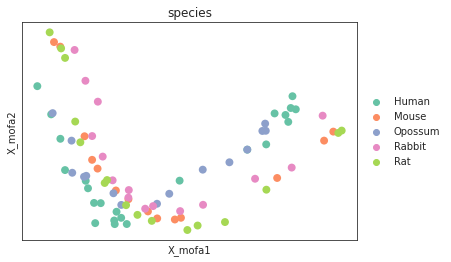

In [14]:
mu.pl.mofa(mdata, color="species", size = 250)

... storing 'species' as categorical


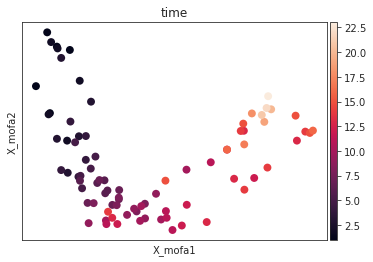

In [15]:
mu.pl.mofa(mdata, color="time", size = 250)

... storing 'species' as categorical


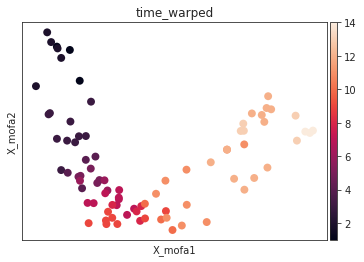

In [16]:
mu.pl.mofa(mdata, color="time_warped", size = 250)

## Latent factors versus common developmental time

We can plot the latent processes along the inferred common developmental time.

Before alignment:

<AxesSubplot:xlabel='time', ylabel='Factor1'>

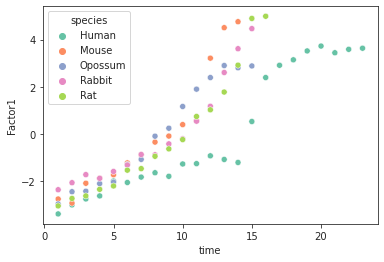

In [17]:
import seaborn as sns
df = pd.DataFrame({'time' : mdata.obs['time'], 'Factor1' : mdata.obsm['X_mofa'][:,0], 'species' : mdata.obs['species']})
sns.scatterplot(x = "time", y = "Factor1", hue = "species", data = df)

After alignment:

<AxesSubplot:xlabel='time', ylabel='Factor1'>

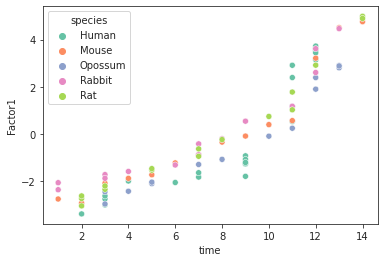

In [19]:
df = pd.DataFrame({'time' : mdata.obs['time_warped'], 'Factor1' : mdata.obsm['X_mofa'][:,0], 'species' : mdata.obs['species']})
sns.scatterplot(x = "time", y = "Factor1", hue = "species", data = df)

## Alignment

We can also take a look at the learnt alignemnt.

<AxesSubplot:xlabel='time', ylabel='time_warped'>

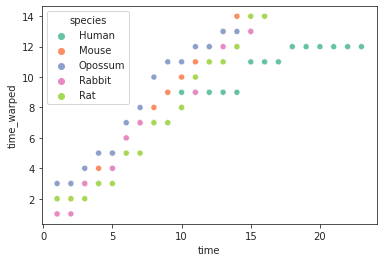

In [18]:
sns.scatterplot(x = "time", y = "time_warped", hue = "species", data = mdata.obs)

## Further analyses

Additionally we can take a look at the smoothness and sharedness of the factors, interpolate the factors or cluster the species based on the learnt group kernel of each latent factor.
This is not yet implemented for muon and can be done from R as described [here](https://raw.githack.com/bioFAM/MEFISTO_tutorials/master/evodevo_tutorial.html).